In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme(style='whitegrid')

#### Define global variables

In [4]:
NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']

## Load the data

In [5]:
train = np.load('fashion_train.npy')
test = np.load('fashion_test.npy')

X_train, y_train = train[:, :784], train[:, 784]
X_test, y_test = test[:, :784], test[:, 784]

# Exploratory Data Analysis

#### Numerical variables

In [6]:
#shape of the data
print(f'Shape of the training data: {X_train.shape}')
print(f'Shape of the testing data: {X_test.shape}')

#mean, std, min, max
print(f'\nMean of the training data: {X_train.mean()}')
print(f'Standard Deviation of the training data: {X_train.std()}')

print(f'\nMin of the training data: {X_train.min()}')
print(f'Max of the training data: {X_train.max()}')


Shape of the training data: (10000, 784)
Shape of the testing data: (5000, 784)

Mean of the training data: 77.02673711734694
Standard Deviation of the training data: 89.9969501937854

Min of the training data: 0
Max of the training data: 255


#### What is the distribution of the target variable?

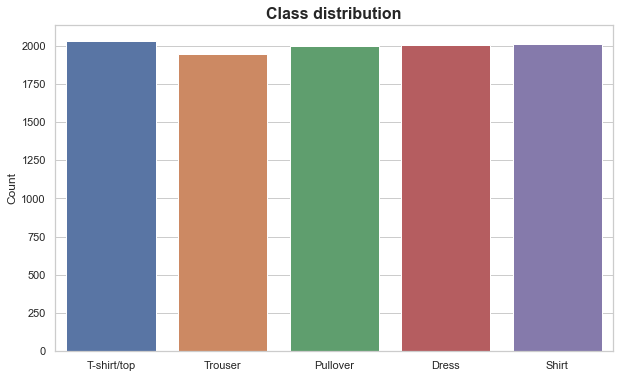

In [7]:
def plot_y_distribution(y):
    ''' Plot the distribution of the labels '''
    classes, classes_counts = np.unique(y, return_counts=True)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=classes, y=classes_counts, ax=ax);
    ax.set_title('Class distribution', fontsize=16, fontweight='bold');
    ax.set_ylabel('Count');
    ax.set_xticklabels(NAMES);


plot_y_distribution(y_train)

#### What are the properties of images in the dataset?
We investigate mean, median, and stdev of the pixel values in the images.

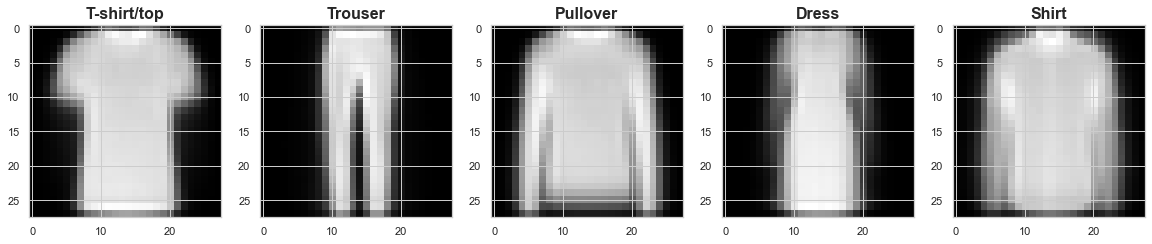

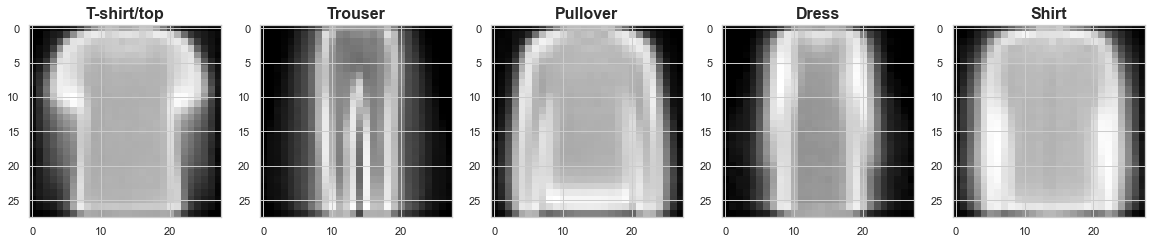

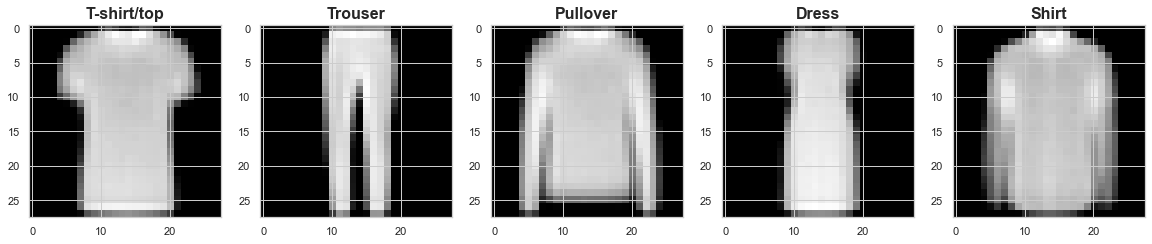

In [8]:
def plot_images(X, y, measure='mean'):
    ''' Plot the mean, median, or std of the images'''
    classes = np.unique(y)
    fig, ax = plt.subplots(1, len(classes), figsize=(20, 8))
    for c in classes:
        imgs = X[y == c]

        if measure == 'mean': av_img = np.mean(imgs, axis=0).reshape(28, 28)
        elif measure == 'median': av_img = np.median(imgs, axis=0).reshape(28, 28)
        elif measure == 'std': av_img = np.std(imgs, axis=0).reshape(28, 28)

        ax[c].imshow(av_img, cmap='gray')
        ax[c].set_title(NAMES[c], fontsize=16, fontweight='bold')


plot_images(X_train, y_train)
plot_images(X_train, y_train, measure='std')
plot_images(X_train, y_train, measure='median')

We also investigate the distribution of the pixel values in the images. As an input, we use the mean of the pixel values in the images.

In [9]:
def plot_color_distribution(X, y):
    ''' Plot the distribution of the colors '''
    classes = np.unique(y)
    av_imgs = np.zeros((len(classes), 28, 28))
    for c in classes:
        imgs = X[y == c]
        av_imgs[c] = np.mean(imgs, axis=0).reshape(28, 28)

    #plot the distribution of the average image
    fig, ax = plt.subplots(1, len(classes), figsize=(30, 6))
    for c in classes:
        sns.histplot(av_imgs[c].flatten(), ax=ax[c], kde=True)
        ax[c].set_title(NAMES[c], fontsize=16, fontweight='bold')
        ax[c].set_xlabel('Pixel value')
        ax[c].set_ylabel('Count')

#plot_color_distribution(X_train, y_train)

# Neural Network

In [10]:
class MiniBatchGD:
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def sample(self):
        ''' Sample a batch of data '''
        idx = np.random.choice(self.X.shape[0], self.batch_size, replace=False)
        return self.X[idx], self.y[idx]

In [11]:
class ActivationFunction:
    def __init__(self, name, lr=0.5):
        self.name = name
        self.lr = lr

    def calculate(self, x, derivative=False):
        if self.name == 'sigmoid':
            return self.sigmoid(x, derivative=derivative)
        elif self.name == 'relu':
            return self.relu(x, derivative=derivative)
        elif self.name == 'leaky_relu':
            return self.leaky_relu(x, derivative=derivative)
        elif self.name == 'softmax':
            return self.softmax(x, derivative=derivative)
        elif self.name == 'tanh':
            return self.tanh(x, derivative=derivative)

    def sigmoid(self, x, derivative=False):
        ''' 
            sigmoid activation function and its derivative 
        '''
        if not derivative:
            return 1 / (1 + np.exp (-x))
        else:
            out = self.sigmoid(x)
            return out * (1 - out)

    def relu(self, x, derivative=False):
        ''' 
            relu activation function and its derivative 
        '''
        if not derivative:
            return np.where(x > 0, x, 0)
        else:
            return np.where(x > 0, 1, 0)

    def leaky_relu(self, x, derivative=False):
        ''' 
            leaky relu activation function and its derivative 
        '''
        if not derivative:
            #print('derivative')
            #print(x[0][0])
            return np.where(x > 0, x, self.lr * x)
        else:
            return np.where(x > 0, 1, self.lr)
    
    def softmax(self, x, derivative=False):
        ''' 
            softmax activation function and its derivative 
        '''
        if not derivative:
            exps = np.exp(x - np.max(x))
            return exps / np.sum(exps)
        else:
            out = self.softmax(x)
            return out * (1 - out)

    def tanh(self, x, derivative=False):
        '''
            tanh activation function and its derivative
        '''
        if not derivative:
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        else:
            out = self.tanh(x)
            return 1 - np.power(out, 2)

In [12]:

class NeuralNetwork:
    def __init__(self, input_size=784, hidden_size=300, output_size=5, layers_num=3, learning_rate=0.01, test=False, activation_name='sigmoid'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size 
        self.layers_num = layers_num
        self.lr = learning_rate
        self.activation = ActivationFunction(activation_name, lr=learning_rate)

        self.weights = []
        self.bias = []

        #self.weights.append(np.random.randn(self.input_size, self.hidden_size))
        #construct the weights using he initialization
        self.weights.append(np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2 / self.input_size))
        
        #self.bias.append(np.random.randn(1, self.hidden_size))
        self.bias.append(np.zeros((1, self.hidden_size)))

        self.weights.append(np.random.randn(self.hidden_size, self.output_size))
        #self.bias.append(np.random.randn(1, self.output_size))
        self.bias.append(np.zeros((1, self.output_size)))
        
    def forward_pass(self, X):
        ''' 
            conduct the forward pass on the network 
        '''
        X = X / 255
        self.z1 = np.dot(X, self.weights[0]) + self.bias[0]
        self.a1 = self.activation.calculate(self.z1)

        self.z2 = np.dot(self.a1, self.weights[1]) + self.bias[1]
        self.a2 = self.activation.calculate(self.z2)
        #print(np.dot(self.a1, self.weights[1])[0][0], self.bias[1][0][0])
        #print(self.z2[0][0])

        self.outputs = np.zeros((len(self.a2), self.output_size))
        for i in range(len(self.a2)):
            self.outputs[i][np.argmax(self.a2[i])] = 1

        self.outputs = np.array(self.outputs)


    def backward_pass(self, X, y):
        '''
            conduct the backward pass on the network
        '''
        X = X / 255
        y_mtrix = np.zeros((len(y), int(self.output_size))) 
        #change y into 1-hot encoding by assigning 1 to the index of the label
        for i in range(len(y)):
            y_mtrix[i][y[i]] = 1

        #loss, used to check the accuracy of the network
        self.loss = np.sum((self.outputs - y_mtrix)**2) / (2*y_mtrix.size)

        #accuracy, used to check the accuracy of the network
        self.accuracy = np.sum(np.argmax(self.outputs, axis=1) == y) / len(y)

        #calculate the error of the hidden layer
        self.e1 = self.a2 - y_mtrix
        dw1 = self.e1 * self.activation.calculate(self.a2, True)
        #print(self.e1[0])
        #print(self.activation.calculate(self.a2, True)[0])
        #print(dw1[0][0])
        
        #calculate the error of the input layer
        self.e2 = np.dot(dw1, self.weights[1].T)
        dw2 = self.e2 * self.activation.calculate(self.a1, True)

        #update the weights
        w2_update = np.dot(self.a1.T, dw1) / len(X)
        w1_update = np.dot(X.T, dw2) / len(X)

        #update the biases
        b2_update = self.lr * np.sum(dw1, axis=0, keepdims=True) / len(X)
        b1_update = self.lr * np.sum(dw2, axis=0, keepdims=True) / len(X) 

        self.weights[1] -= self.lr * w2_update
        self.weights[0] -= self.lr * w1_update

        self.bias[1] -= self.lr * b2_update
        self.bias[0] -= self.lr * b1_update

        #print(self.weights[0])

        
    def TRAIN(self, X, y, epochs=5, testing=False):
        '''
            train the network for a given number of epochs
        '''
        for epoch in range(epochs):
            X_sample, y_sample = MiniBatchGD(X, y, batch_size=128).sample()
            self.forward_pass(X_sample)
            self.backward_pass(X_sample, y_sample)
            if testing: print(f'Epoch {epoch}, loss: {self.loss}, accuracy: {self.accuracy}')

    def TEST(self, X, y):
        '''
            test the network
        '''
        self.forward_pass(X)
        self.backward_pass(X, y)
        print(f'loss: {self.loss}, accuracy: {self.accuracy}')
    

In [13]:
#activation function
# and regularization

nn = NeuralNetwork(test=True, activation_name='sigmoid')
nn.TRAIN(X_train, y_train, epochs=200, testing=True)
nn.TEST(X_test, y_test)


Epoch 0, loss: 0.1640625, accuracy: 0.1796875
Epoch 1, loss: 0.1703125, accuracy: 0.1484375
Epoch 2, loss: 0.1421875, accuracy: 0.2890625
Epoch 3, loss: 0.146875, accuracy: 0.265625
Epoch 4, loss: 0.1421875, accuracy: 0.2890625
Epoch 5, loss: 0.1453125, accuracy: 0.2734375
Epoch 6, loss: 0.1375, accuracy: 0.3125
Epoch 7, loss: 0.1328125, accuracy: 0.3359375
Epoch 8, loss: 0.1453125, accuracy: 0.2734375
Epoch 9, loss: 0.1421875, accuracy: 0.2890625
Epoch 10, loss: 0.140625, accuracy: 0.296875
Epoch 11, loss: 0.13125, accuracy: 0.34375
Epoch 12, loss: 0.121875, accuracy: 0.390625
Epoch 13, loss: 0.1390625, accuracy: 0.3046875
Epoch 14, loss: 0.13125, accuracy: 0.34375
Epoch 15, loss: 0.121875, accuracy: 0.390625
Epoch 16, loss: 0.1046875, accuracy: 0.4765625
Epoch 17, loss: 0.1375, accuracy: 0.3125
Epoch 18, loss: 0.121875, accuracy: 0.390625
Epoch 19, loss: 0.140625, accuracy: 0.296875
Epoch 20, loss: 0.11875, accuracy: 0.40625
Epoch 21, loss: 0.134375, accuracy: 0.328125
Epoch 22, loss

# Decision Tree

### Feature Extraction

In [14]:
df = pd.DataFrame()

#### Size of the object

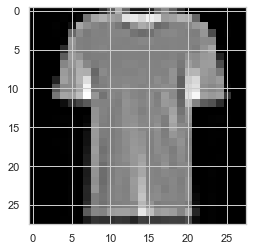

In [15]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray');

### Decision Tree Algorithm

In [16]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value


In [17]:
class InformationGain:
    def __init__(self, parent, l_child, r_child, mode='entropy'):
        self.l_child = l_child
        self.r_child = r_child
        self.weight_l, self.weight_r = len(l_child) / len(parent), len(r_child) / len(parent)
        self.mode = mode
        self.parent = parent
        

    def calculate(self):
        if self.mode=='gini':
            return self.gini(self.parent) - (self.weight_l*self.gini(self.l_child) + self.weight_r*self.gini(self.r_child))
        elif self.mode=='entropy':
            return self.entropy(self.parent) - (self.weight_l*self.entropy(self.l_child) + self.weight_r*self.entropy(self.r_child))


    def entropy(self, y):
        ''' 
            function to compute entropy 
        '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini_i = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini_i

In [35]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=5, mode='entropy'):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        self.mode = mode
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float('inf')
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_information_gain = InformationGain(y, left_y, right_y, mode=self.mode).calculate()
                    # update the best split if needed
                    if curr_information_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_information_gain
                        max_info_gain = curr_information_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    



In [36]:
#X_t = X_train.reshape(-1, 28, 28)
#X_te = X_test.reshape(-1, 28, 28)
#df = pd.DataFrame(X_train)
#df.columns = [f'column-{i}' for i in range(784)]
#df['label'] = y_train


In [37]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

#select only first 50 images
X_train = X_train[:50]
x = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=3)
pcax = pca.fit_transform(x)
df = pd.DataFrame(data = pcax, columns= ['pc 1', 'pc 2', 'pc 3'])
#final_df = pd.concat([principal_df, pd.DataFrame(area, columns = ['area'])], axis = 1); 
#final_df = pd.concat([final_df, pd.DataFrame(train_y, columns = ['y'])], axis = 1)

df.head()


ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

In [39]:

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score

#print(accuracy_score(Y_test, Y_pred))

classifier.print_tree()

print(Y_pred)



X_0 <= 1.518764191852642 ? 1.0000000000000009
 left:X_0 <= -9.422743562405353 ? 1.0000000000000004
  left:X_0 <= -14.714768142519818 ? 1.0
    left:X_0 <= -16.52930391783641 ? 0.9709505944546686
        left:0.04133280446532885
        right:2.6874614216076265
    right:X_0 <= -12.913330841930605 ? 0.9709505944546686
        left:3.755027344008868
        right:1.154648961503946
  right:X_0 <= -6.601962985193571 ? 1.0
    left:X_0 <= -9.060741432927907 ? 0.9709505944546686
        left:1.8916638689767376
        right:4.753401206712189
    right:X_0 <= -3.82044844816818 ? 0.9709505944546686
        left:-9.477784557348494
        right:4.150394167808943
 right:X_0 <= 8.373273790290755 ? 1.0000000000000004
  left:X_0 <= 5.352551913437541 ? 1.0
    left:X_0 <= 2.0009150674439846 ? 0.9709505944546686
        left:9.525354639600318
        right:-0.13572569880680885
    right:X_0 <= 6.548314974870716 ? 0.9709505944546686
        left:-1.1840719567662765
        right:-14.604932870473167
  